## Introduction
The ventilator generates positive pressure which is applied to the respiratory system $P_{rs}$. Assisted ventilation can be total, partial or absent, depending on respiratory muscles’ ability to generate additional pressure to the respiratory system $P_{rs}$.

$P_{rs}$. of a ventilated patient is the sum of the pressure generated by the ventilator ($P_{aw}$.) and the pressure developed by the respiratory muscles ($P_{mus}$). Note that $P_{mus}$. is negative, as inspiratory muscles act by producing a decrease in pressure below the airways.

## Inspiration
During inspiration, the relationship between pressure, and flow is described by the equation of motion: 
$$P_{rs} = P_{aw} + (-P_{mus}) = \dot{V}\times R + \frac{V}{C} + PEEP$$
Note that flow is the change of volume per time, and hence the notation $\dot{V} = Flow$. Also, note that $PEEP$ is a constant representing the alveolar end expiratory pressure.

The term $\dot{V} \times R$ reads as **flow times resistance**  and corresponds to the pressure dissipated across the airway and the endotracheal tube, and to overcome the frictional forces generated with gas flow.

The term ${V}/{C}$ reads as **volume divided by compliance** and corresponds to the pressure that must be applied to overcome elastic forces of the lungs. It depends on both the volume that is in the lungs in excess on resting volume ($FRC$), and on the respiratory system compliance.

## Expiration
Expiration is passive, and the flow is described using the exponential decay equation which can be written as a first order differential equation $\dot{V} = -\lambda V$ or $\dot{V} = -{1\over\tau} V$.

A solution to the above equation is $V= V_0 e^{-\lambda t}$, which can also be written as $V= V_0 e^{-t\over\tau}$.

Note that *tau* is a property of the respiratory system, and is a constant equaling the **compliance times resistance**. This can be written as $\tau=C \times R= -V / \dot{V}$.

## Approach to solution in volume-control mode
### 1. Calculating Flow
We represent flow $\dot{V}$ as a function of time $t$. This is a periodic function where the period is the breath duration defined as $T_{breath} = 60/RR$, where $RR$ is the set respiratory rate per minute. Each period (or cycle) has an inspiratory phase, and a expiratory phase. 
- The inspiratory time ($T_i$) is calculated using the set flow ($Flow$), and tidal volume ($TV$):
 - For a fixed (square) flow: $T_i = TV / Flow$.
 - For a deccelerating flow: $T_i = 2 \times TV / Flow$.
- The expiratory time ($Te$) is the difference between the breath duration, and the inspiratory time $T_e = T_{breath} - T_i$

#### Fixed Flow
For a ventilator in volume-control mode, and a square flow wave, we can write the function as follows: 

$$\dot{V}={{dV}\over{dt}}=\begin{cases}
    Flow & \text{if in inspiration which can be expressed as } (t \space\%\space T_{breath} \leqslant T_i) \\
    {-V(t)/\tau} & \text{if in expiration which can be expressed as } (t \space\%\space T_{breath} > T_i)
\end{cases}$$


Note that $Flow$ is a constant representing the set flow, and ($\%$) is the modulo operator.

#### Decelerating Flow
In a decelearting inspiratory flow, the inspiratory flow starts at the set flow, and decreased to zero at the end of inspiration. This can be written as:

$$\dot{V}={{dV}\over{dt}}=
  \begin{cases}
    Flow \times (1 - t/T_i) & \text{if } t \space\%\space T_{breath} \leqslant T_i\\
    {-V(t)/\tau} & \text{otherwise}
  \end{cases}$$

### 2. Calculating Volume
Once $\dot{V}$ is calculated, it is easy to calculate the volume as follows $V = \dot{V} \times{dt}$

### 3. Calculating Pressures
Once flow, and volume values are calculated, it is easy to calculate the airway and alveloar pressures using the equation of motion assuming the patient is not contributing to the respiratory effort $P_{mus} = 0$.

$$P_{alv} = V/C + PEEP \text{ and } P_{aw} = \dot{V}R + P_{alv}$$


## Programming the volume-control mode solution
The equation for ${V}$ that is defined above is a first order differential equation. The program below generates a solution using Euler method which is a numerical method to solve first order first degree differential equation with a given initial value. 

To start, we define 3 data structures(objects) that hold the *simulation settings*, *ventilator parameters*, and *lung charecterisitcs* respectively. **You can change the values** in these objects, and this will update the simulation and the resulting waveforms. 

In [33]:
# Libraries used in the notebook
from collections import namedtuple
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set_style("darkgrid")

In [34]:
# the tuple represents the properties of the respiratory system (lungs & airways)
# R - resistance of the airways in cmH2O/L/sec 
# C - the compliance of the lungs in L/cmH2O
# V0 - the initial volume in the lungs in liters
Lung = namedtuple('Lung', ['R', 'C', 'V0'])

In [35]:
# the tuple represents the settings for a vent in a pressure-controlled setting
# TV - tial volume in liters
# F - flow in liters per minute
# PEEP - in cmH2O
# RR - respiratory rate per minute
# Wave - flow waveform either SQ (square) or DEC (decelerating)
VentVC = namedtuple('VentVC', ['RR', 'TV', 'Flow', 'Wave', 'PEEP'])

In [36]:
def simulateVC(vent:VentVC, lung:Lung, duration=30, dt=0.01):
    """Takes a Vent, and Lung tuples, and returns pressure, flow, and volume values  over the simulation duration"""

    if type(vent).__name__ != "VentVC": raise TypeError("This methods only accepts VentVC")

    breathTime = 60 / vent.RR
    tau = lung.R * lung.C

    # calculate Ti (seconds) based on the flow wave shape
    # for a square flow wave, Ti is TV divded by Flow
    # for a decelarting wave, Ti is 2 * TV/F
    if vent.Wave == "SQ": 
        Ti = vent.TV / (vent.Flow / 60)
    else:
        Ti = 2 * vent.TV / (vent.Flow / 60)

    time = np.arange(0, duration, dt)
    timeInCycle = time % breathTime
    inspInCycle = timeInCycle < Ti

    # calculate volume, and flow over time
    V = np.zeros(len(time))
    V[0] = lung.V0
    F = np.zeros(len(time))
    dv = 0

    for t in range(len(time) - 1):
        if inspInCycle[t]:      # in inspiration
            if vent.Wave == 'SQ': F[t] = vent.Flow / 60
            else: F[t] = (vent.Flow / 60) * (1 - timeInCycle[t]/Ti)
            dv = F[t] * dt
            V[t+1] = V[t] + dv
        else:                   # in expiration
            dv = (-V[t]/tau) * dt   # exponential decay in derivative form
            V[t+1] = V[t] + dv
            F[t] = dv/dt

    # calcualte Palv, and Paw
    Palv = V/lung.C + vent.PEEP
    Paw = F*lung.R + Palv

    return time, Paw, Palv, V, F

In [43]:
def plot(time, Paw, Palv, V, F):
    """Takes arrays representing time, pressure, volume, and flow values for a lung-ventilator scenario, 
    and plots the waveforms, and loops"""

    # plot pressure, flow, and volume wavforms
    plt.figure(1, figsize=(15, 6))
    plt.subplot(311)
    plt.title("Ventilator Waveforms")
    plt.plot(time, Paw, label = "Paw")
    plt.plot(time, Palv, "r--", label = "Palv", alpha = 0.5)
    plt.legend()
    plt.ylabel("Pressure (cmH20)")
    plt.subplot(312)
    plt.plot(time, F*60)
    plt.ylabel("Flow (L/min)")
    plt.subplot(313)
    plt.plot(time, V*1000)
    plt.ylabel("Volume (mL)")
    
    return plt.show()

TEST VC
--Square Flow--
VentVC(RR=12, TV=0.5, Flow=60, Wave='SQ', PEEP=5)
Lung(R=10, C=0.1, V0=0)


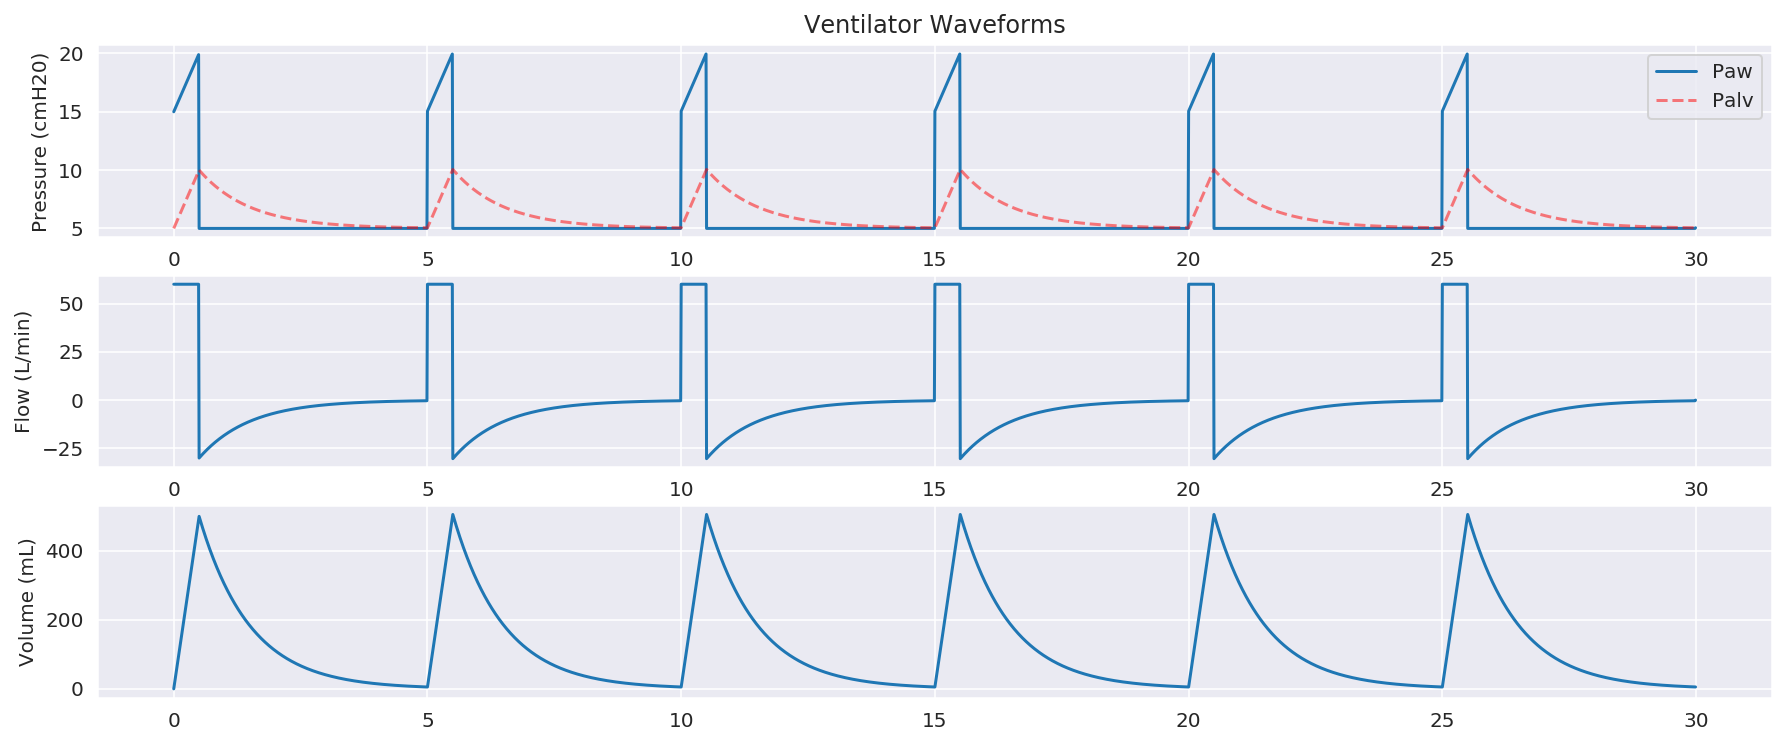

--Decelerating Flow--
VentVC(RR=12, TV=0.5, Flow=60, Wave='DEC', PEEP=5)
Lung(R=10, C=0.1, V0=0)


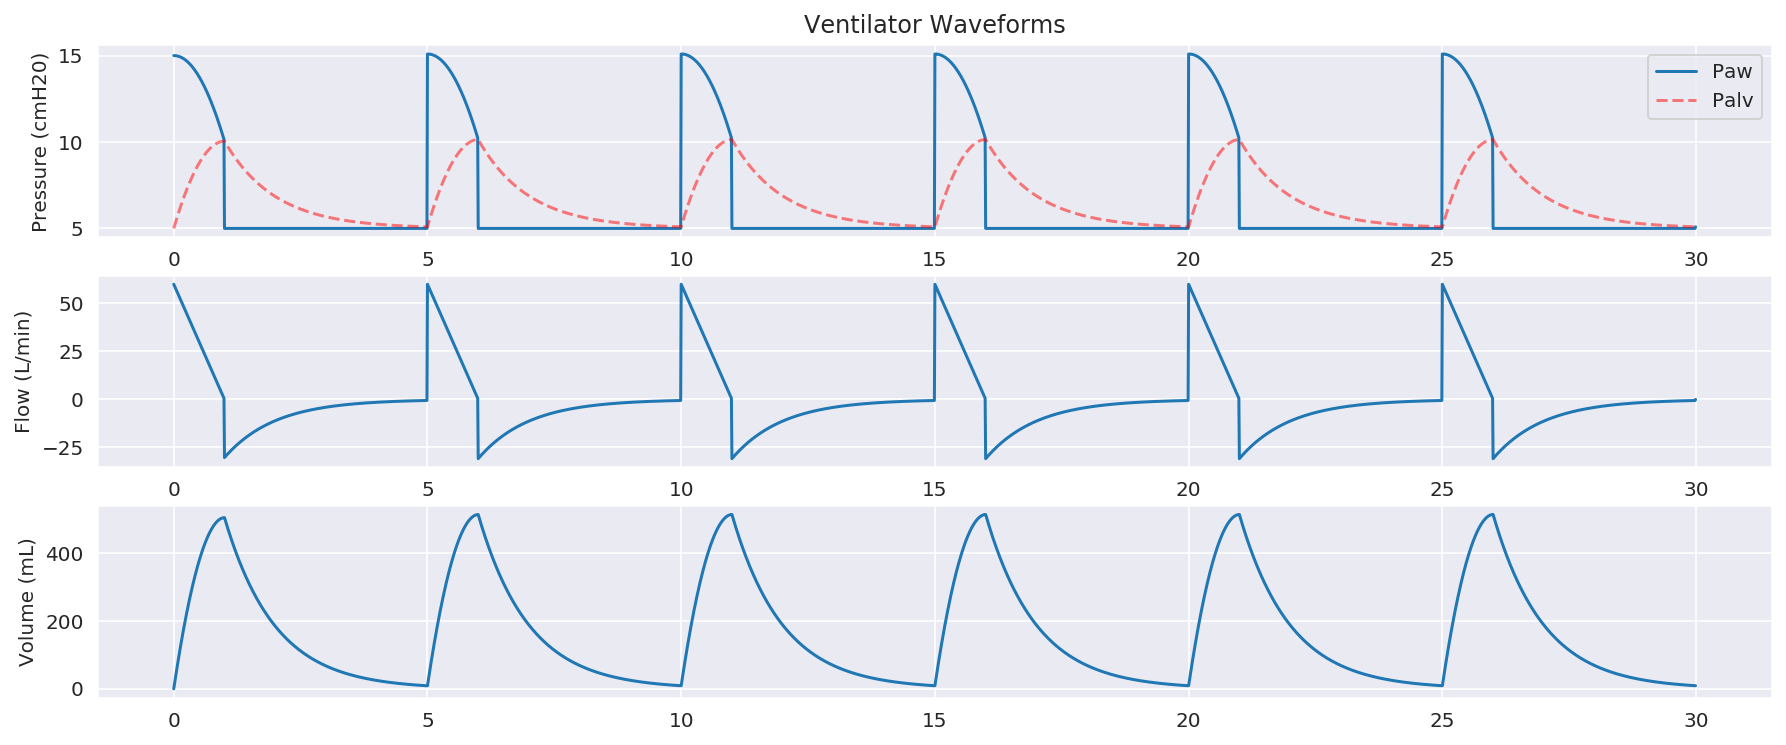

In [38]:
lung = Lung(10, 0.1, 0)

print("TEST VC")
print("--Square Flow--")
vent1 = VentVC(12, 0.5, 60, 'SQ', 5)
time, paw, palv, v, f = simulateVC(vent1, lung)
print(vent1)
print(lung)
plot(time, paw, palv, v, f)

print("--Decelerating Flow--")
vent2 = VentVC(12, 0.5, 60, 'DEC', 5)
time, paw, palv, v, f = simulateVC(vent2, lung)
print(vent2) 
print(lung)
plot(time, paw, palv, v, f)

## Approach to solution in pressure-control mode
### 1. Calculating Pressure
Inspiratory time $Ti$ is a constant that's set by the vent. Pressure is equal to $P_i$ during inspiration and $PEEP$ during expiration. This can be expressed as:

$$P_{aw}(t)=\begin{cases}
    P_i & \text{ if } t \space\%\space T_{breath} \leqslant T_i\\
    PEEP & \text{ if } t \space\%\space T_{breath} > T_i
\end{cases}$$


### 2. Calculating Flow
We represent flow $\dot{V}$ as a function of time $t$. This is a periodic function where the period is the breath duration defined as $T_{breath} = 60/RR$, where $RR$ is the set respiratory rate per minute. Each period (or cycle) has an inspiratory phase, and a expiratory phase. 

For a ventilator in pressure-control mode, we can write the function as follows: 

$$\dot{V}={{dV}\over{dt}}=\begin{cases}
    \frac{P_{aw}(t) - V(t)/C - PEEP}{R}  & \text{ if } (t \space\%\space T_{breath} \leqslant T_i) \\
    {-V(t)/\tau} & \text{ if } (t \space\%\space T_{breath} > T_i)
\end{cases}$$

### 3. Calculating Volume
Once $\dot{V}$ is calculated, it is easy to calculate the volume as follows $V = \dot{V} \times{dt}$


## Programming the volume-control mode solution

In [39]:
# the tuple represents the settings for a vent in a pressure-controlled setting
# Pi - inspiratory pressure in cmH2O
# PEEP - in cmH2O
# RR - respiratory rate per minute
# Tinsp - time for inspiration in seconds
VentPC = namedtuple('VentPC', ['RR', 'Pi', 'Tinsp','PEEP'])

In [40]:
def simulatePC(vent:VentPC, lung:Lung, duration=30, dt=0.01):
    """Takes a Vent, and Lung, and returns pressure, flow, and volume values over the simulation duration"""
    if type(vent).__name__ != "VentPC": raise TypeError("This methods only accepts VentPC")
    
    breathTime = 60 / vent.RR
    Ti = vent.Tinsp

    time = np.arange(0, duration, dt)
    timeInCycle = time % breathTime
    inspInCycle = timeInCycle < Ti

    # airway pressure is equal to the vent Pi pressure during inspiration and PEEP during expiration
    Paw = [vent.Pi if insp else vent.PEEP for insp in inspInCycle]

    # calculate volume, and flow over time
    V = np.zeros(len(time))
    V[0] = lung.V0
    F = np.zeros(len(time))
    for t in range(len(time)-1):
        dv = (Paw[t] - V[t]/lung.C - vent.PEEP) / lung.R * dt
        V[t+1] = V[t] + dv
        F[t] = dv/dt

    # calcualte Palv
    Palv = V/lung.C + vent.PEEP

    return time, Paw, Palv, V, F

TEST PC
VentPC(RR=12, Pi=15, Tinsp=1, PEEP=5)
Lung(R=10, C=0.1, V0=0)


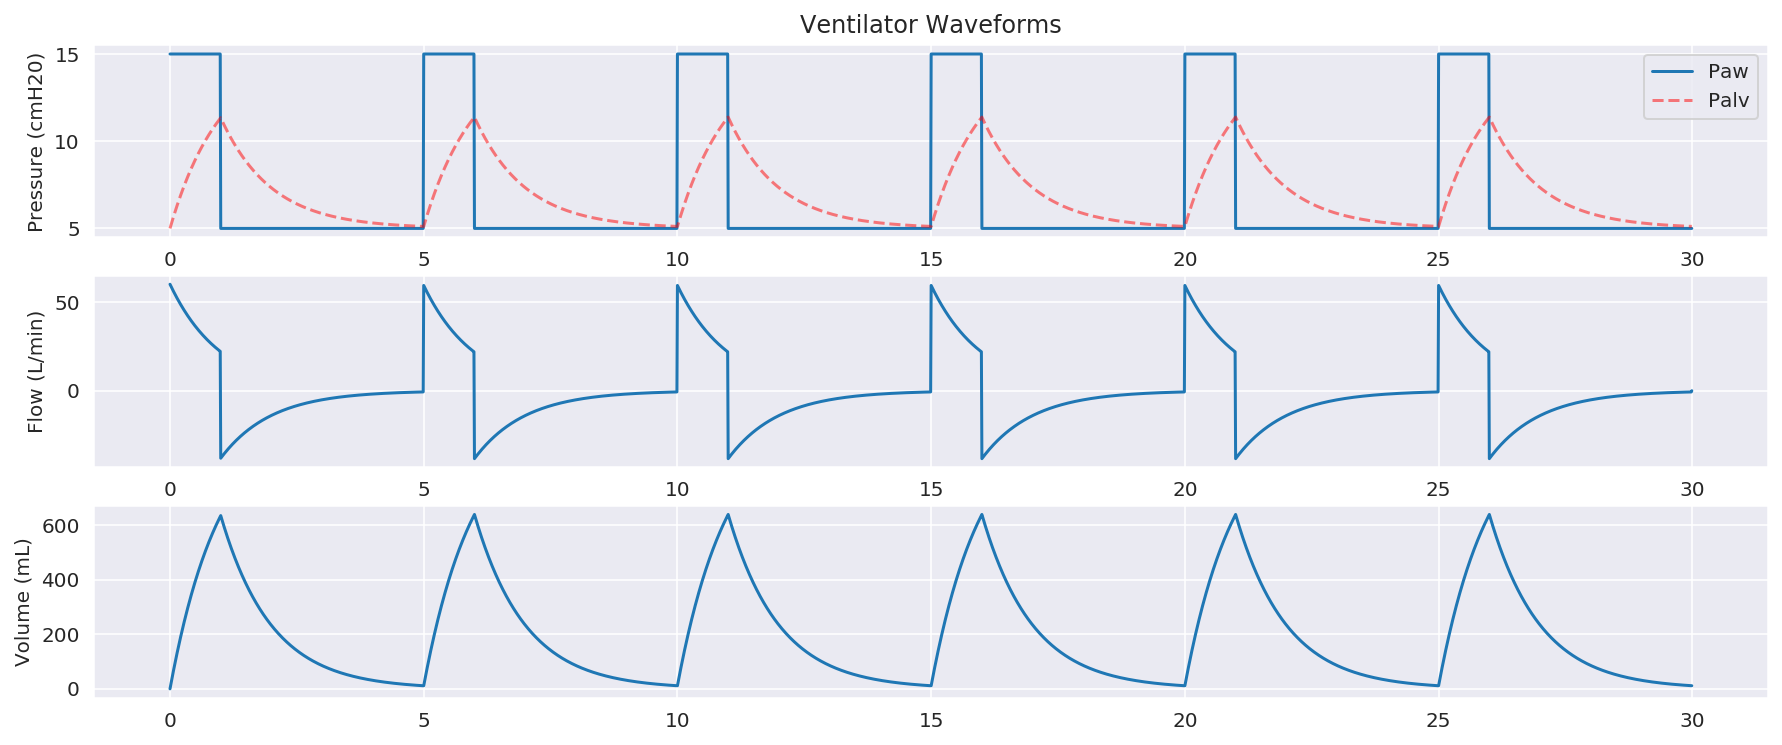

In [42]:
print("TEST PC")
vent = VentPC(12, 15, 1, 5)
lung = Lung(10, 0.1, 0)
time, paw, palv, v, f = simulatePC(vent, lung)
print(vent)
print(lung)
plot(time, paw, palv, v, f)